### calculate the correlation between the 6 region's time-series and some GCM derived fields 

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt

In [2]:
import sys
import pathlib
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import numpy as np 
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs 

### parameters 

In [4]:
provider = 'CDS'
GCM = 'ECMWF'
varname = 'T2M'
target_var = 'TMEAN'

In [5]:
HOME = pathlib.Path.home() 
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append(str(HOME.joinpath("research/Smart_Ideas/code"))) 

In [9]:
from ml4seas.utils import * 
from ml4seas.GCM import shift_dset_time

In [10]:
dpath_gcm = pathlib.Path(f'/media/nicolasf/END19101/data/GCMs/processed/{provider}/{GCM}/{varname}')

In [11]:
lfiles_gcm = list(dpath_gcm.glob(f"{provider}_{GCM}_{varname}_*_seasonal_anomalies_1981_2010_clim.nc")) 

In [12]:
lfiles_gcm.sort()

In [13]:
len(lfiles_gcm)

468

In [14]:
dset_gcm = xr.open_mfdataset(lfiles_gcm, concat_dim='time', combine='nested')

### calculate the ensemble mean for now 

In [15]:
dset_gcm = dset_gcm.mean('member')

In [16]:
dset_gcm

,Array,Chunk
Bytes,487.92 MB,1.04 MB
Shape,"(468, 4, 181, 360)","(1, 4, 181, 360)"
Count,2808 Tasks,468 Chunks
Type,float32,numpy.ndarray


In [17]:
dset_gcm['time'] = (('time'), dset_gcm.init_time.to_index() + pd.offsets.MonthEnd(0))

In [18]:
dset_gcm = dset_gcm.drop(["init_time","month"])

In [19]:
dpath_regions = pathlib.Path(HOME.joinpath(f"research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/{target_var}")) 

In [20]:
list_regions = ['NNI','WNI','ENI','NSI','WSI','ESI']

In [21]:
df = []
for region in list_regions: 
    data = pd.read_csv(dpath_regions.joinpath(f"{region}/TS_NZ_region_{region}_{target_var}_3_quantiles_anoms.csv"), index_col=0, parse_dates=True)
    data = data.loc[:,['anomalies']]
    data.columns = [region]
    df.append(data) 

In [22]:
df = pd.concat(df, axis=1)

In [23]:
df_xr = df.to_xarray()

In [24]:
dset_gcm

,Array,Chunk
Bytes,487.92 MB,1.04 MB
Shape,"(468, 4, 181, 360)","(1, 4, 181, 360)"
Count,2808 Tasks,468 Chunks
Type,float32,numpy.ndarray


**the steps are 2,3,4,5**

+ 2 = lead times 0,1,2  
+ 3 = lead times 1,2,3 ***    
+ 4 = lead times 2,3,4   
+ 5 = lead times 3,4,5  

In [25]:
region = 'NNI'

warning, the end_month argument is set to True,
            but the time variable does NOT start at the beinning of the month
            
warning, the end_month argument is set to True,
            but the time variable does NOT start at the beinning of the month
            
warning, the end_month argument is set to True,
            but the time variable does NOT start at the beinning of the month
            
warning, the end_month argument is set to True,
            but the time variable does NOT start at the beinning of the month
            


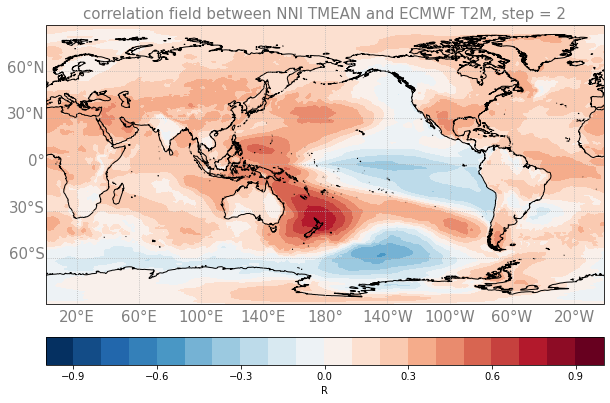

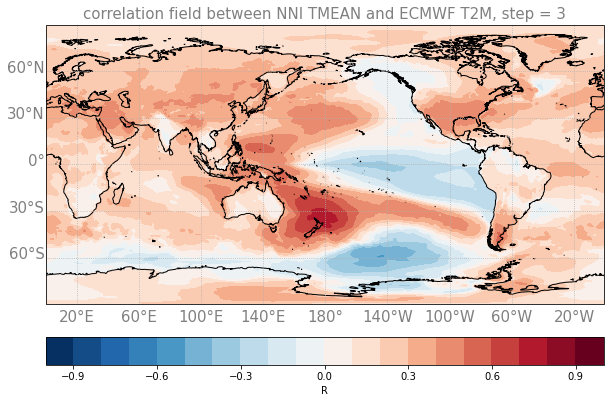

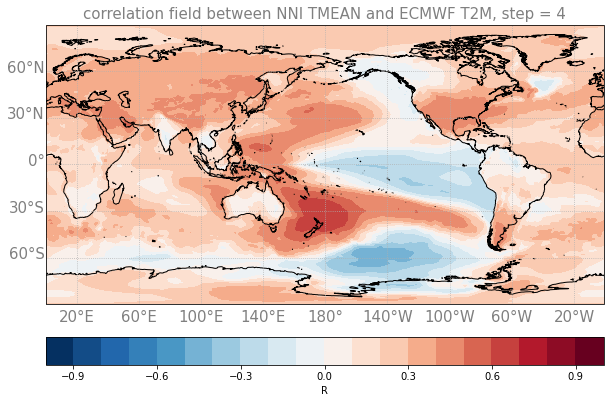

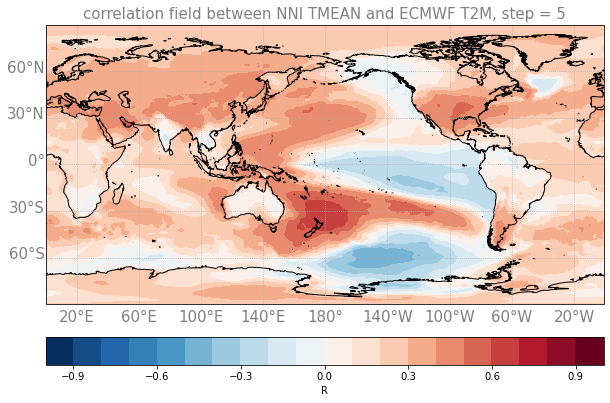

In [26]:
for step in range(2, 5 + 1):
    
    dset = shift_dset_time(dset_gcm, name='time', step=step) 
    
    dset, df_xr = xr.align(dset, df_xr)
    
    R = xr.corr(df_xr[region], dset['t2m'], dim='time')
    
    
    f, ax = plt.subplots(figsize=(10, 12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

    R.sel(step=step).plot.contourf(transform=ccrs.PlateCarree(), levels=np.arange(-1, 1.1, 0.1), \
                                cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'label':'R'})

    ax.coastlines(resolution='50m') 

    gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=np.arange(-180, 180, 40), crs=ccrs.PlateCarree())

    gl.top_labels = False
    gl.right_labels = False

    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.ylabel_style = {'size': 15, 'color': 'gray'}

    ax.set_title(f"correlation field between {region} {target_var} and {GCM} {varname}, step = {step}", fontsize=15, color='gray')
    
    f.savefig(f"R_{region}_{target_var}_{varname}_step_{step}_{GCM}.png", dpi=200, bbox_inches='tight', facecolor='w')